In [1]:
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

Using TensorFlow backend.


Loading the model.

In [2]:
# Restore model.
sess = tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('tf_mnist_model_layers/tf_mnist_model.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('tf_mnist_model_layers/'))

INFO:tensorflow:Restoring parameters from tf_mnist_model_layers/tf_mnist_model.ckpt


Loading the dataset

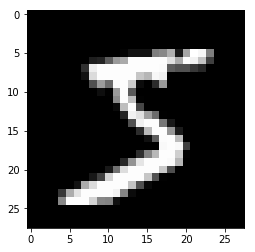

In [3]:
dataset = mnist.load_data()
train_data = dataset[0][0] / 255
train_data = train_data[..., np.newaxis].astype('float32')
train_labels = np_utils.to_categorical(dataset[0][1]).astype('float32')
test_data = dataset[1][0] / 255
test_data = test_data[..., np.newaxis].astype('float32')
test_labels = np_utils.to_categorical(dataset[1][1]).astype('float32')
plt.imshow(train_data[0, ..., 0])

In [4]:
# Get the first input tensor.
network_input = sess.graph.get_operations()[0].outputs[0]
network_input

<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>

## The TensorFlow graph

Look at all operations to find out the ones that are interesting for weights/activations.

In [5]:
sess.graph.get_operations()

[<tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'training/input' type=Const>,
 <tf.Operation 'training' type=PlaceholderWithDefault>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/shape' type=Const>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/mean' type=Const>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/stddev' type=Const>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/TruncatedNormal' type=TruncatedNormal>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal/mul' type=Mul>,
 <tf.Operation 'conv2d_1/kernel/Initializer/truncated_normal' type=Add>,
 <tf.Operation 'conv2d_1/kernel' type=VariableV2>,
 <tf.Operation 'conv2d_1/kernel/Assign' type=Assign>,
 <tf.Operation 'conv2d_1/kernel/read' type=Identity>,
 <tf.Operation 'conv2d_1/bias/Initializer/zeros' type=Const>,
 <tf.Operation 'conv2d_1/bias' type=VariableV2>,
 <tf.Operation 'conv2d_1/bias/Assign'

TensorFlow exposes a graph API in which nodes correspond to operations and directed edges correspond to to tensors flowing from one operation to the next. Operations know their respective input and output tensors. Tensors know by which operations they get produced and for which operations they serve as input. c.f. https://www.tensorflow.org/extend/tool_developers/

In [6]:
conv_op = sess.graph.get_operation_by_name('conv2d_1/convolution')
print('inputs: ', list(conv_op.inputs))
print('outputs: ', list(conv_op.outputs))

inputs:  [<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'conv2d_1/kernel/read:0' shape=(3, 3, 1, 32) dtype=float32>]
outputs:  [<tf.Tensor 'conv2d_1/convolution:0' shape=(?, 26, 26, 32) dtype=float32>]


In [7]:
weight_tensor = conv_op.inputs[1]
weight_tensor

<tf.Tensor 'conv2d_1/kernel/read:0' shape=(3, 3, 1, 32) dtype=float32>

In [10]:
# Producer ops for the tensor.
weight_tensor.op

<tf.Operation 'conv2d_1/kernel/read' type=Identity>

In [11]:
# Consumer ops for the tensor.
weight_tensor.consumers()

[<tf.Operation 'conv2d_1/convolution' type=Conv2D>,
 <tf.Operation 'gradients/conv2d_1/convolution_grad/Conv2DBackpropInput' type=Conv2DBackpropInput>]

### Getting the weights
For getting the weights we need to run the output tensor of operations that read the weights or the seconde input tensor of the actual MatMul/Conv operations.

In [18]:
weight_read_op = sess.graph.get_operation_by_name('conv2d_1/kernel/read')
weight_read_op


<tf.Operation 'conv2d_1/kernel/read' type=Identity>

In [19]:
conv_op = sess.graph.get_operation_by_name('conv2d_1/convolution')
conv_op

<tf.Operation 'conv2d_1/convolution' type=Conv2D>

In [20]:
weights_1 = sess.run(weight_read_op.outputs[0])
weights_2 = sess.run(conv_op.inputs[-1])
np.all(weights_1 == weights_2)

True

Looking at the actual kernels.

(3, 3, 1, 32)


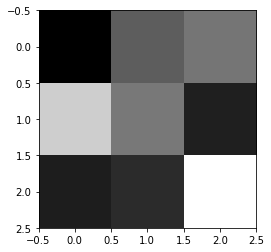

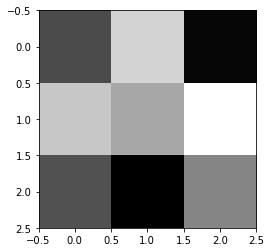

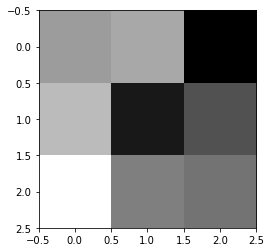

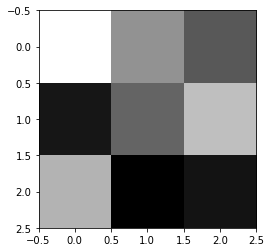

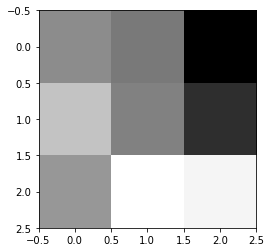

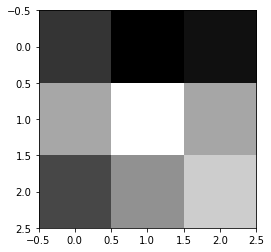

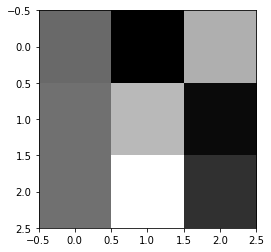

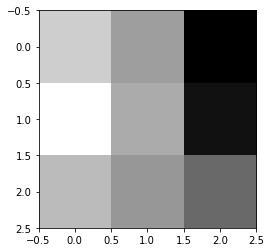

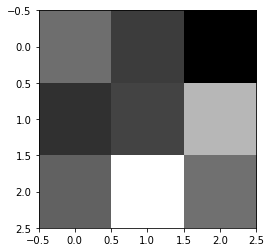

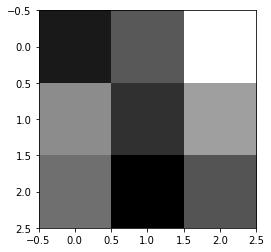

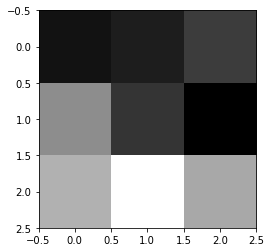

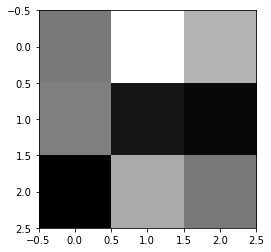

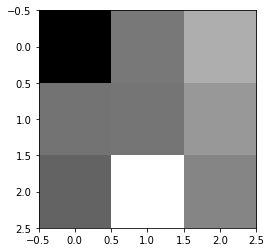

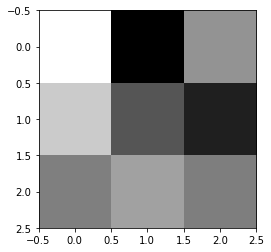

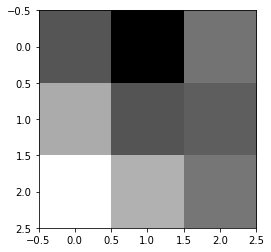

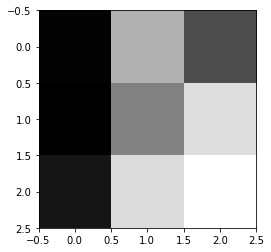

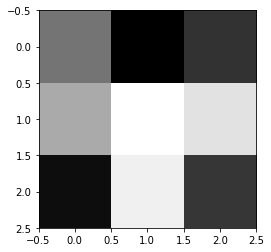

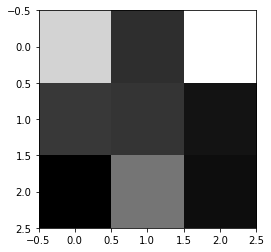

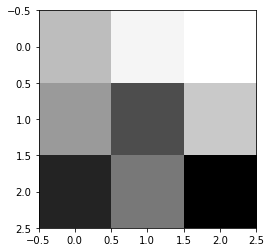

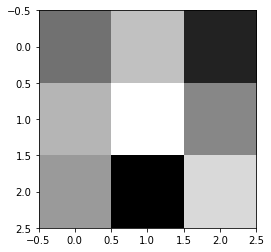

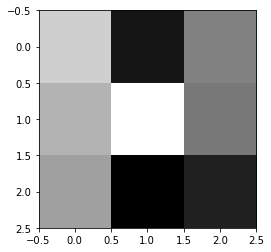

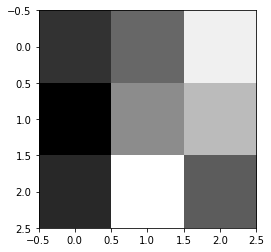

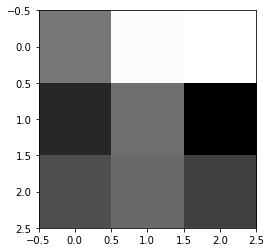

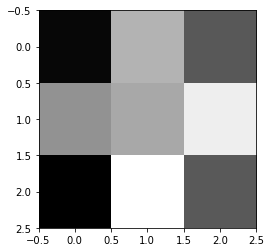

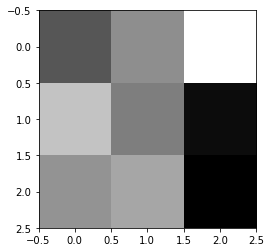

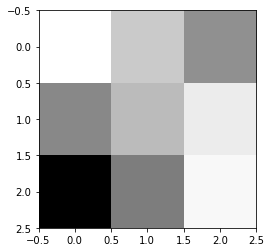

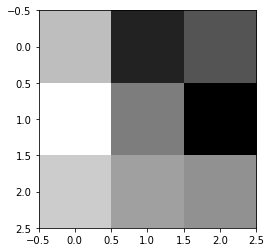

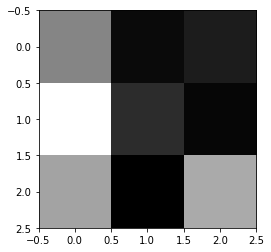

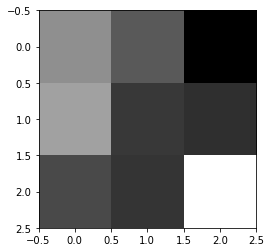

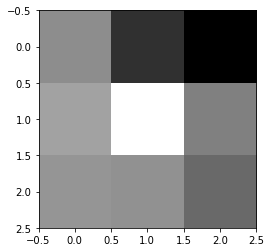

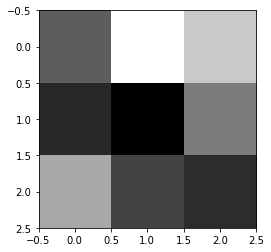

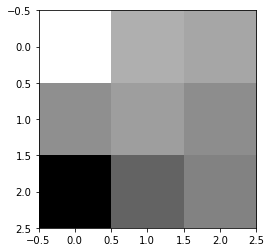

In [21]:
print(weights_1.shape)
for i in range(32):
    plt.imshow(weights_1[..., 0, i])
    plt.show()

In [22]:
weights_1[..., 0, 0]

array([[-0.08219472,  0.01501322,  0.03917561],
       [ 0.13132864,  0.04290215, -0.04941976],
       [-0.05186096, -0.03700988,  0.18301845]], dtype=float32)

The same goes for the bias.

In [23]:
bias_add_op = sess.graph.get_operation_by_name('conv2d_1/BiasAdd')
bias_add_op

<tf.Operation 'conv2d_1/BiasAdd' type=BiasAdd>

In [24]:
bias = sess.run(bias_add_op.inputs[-1])
bias

array([  2.55220849e-03,  -6.17763377e-04,   4.65408294e-03,
         1.22981519e-02,  -2.34646210e-03,  -2.23787036e-04,
        -3.72230512e-04,   2.21268404e-02,   2.86802351e-02,
        -5.76844672e-03,  -2.51290301e-04,   1.05109112e-02,
         4.26664911e-02,  -4.79708280e-04,  -1.47018407e-04,
         3.36357169e-02,   7.37800947e-05,   8.38877633e-04,
         7.63600506e-03,   2.40804045e-04,   8.00278410e-03,
        -1.05535528e-02,   3.01947235e-03,   9.05721821e-03,
         2.59847904e-04,   8.11665133e-03,  -1.28647589e-04,
         3.09362952e-02,  -2.05803127e-03,  -3.35510704e-04,
         1.95620786e-02,  -4.01624449e-04], dtype=float32)

### Getting the activations and net inputs
Activations and net inputs can be found as the output tensors of the respective operations.
Slices of the example code here are used to unit test the `network` package.

In [30]:
activation_op = sess.graph.get_operation_by_name('conv2d_1/Relu')
activation_op.outputs[0]

<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 26, 26, 32) dtype=float32>

In [31]:
activations = sess.run(activation_op.outputs[0], feed_dict={network_input: test_data[0:1]})
activations.shape

(1, 26, 26, 32)

Look at the activations

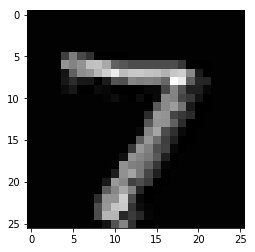

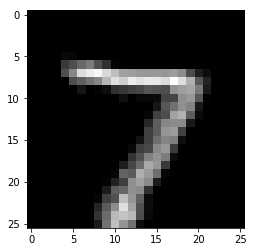

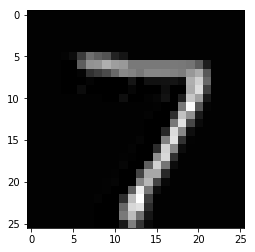

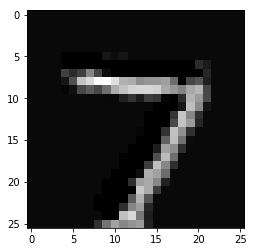

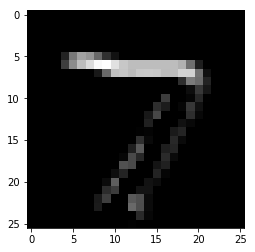

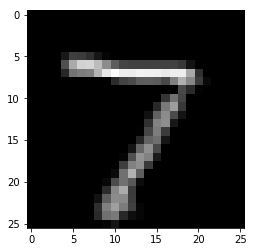

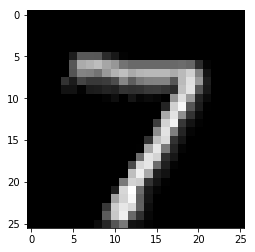

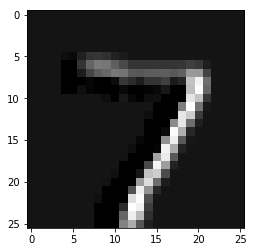

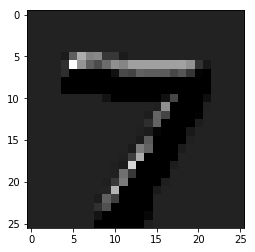

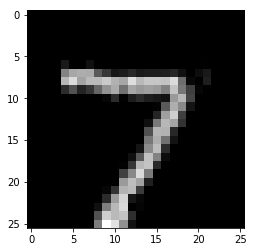

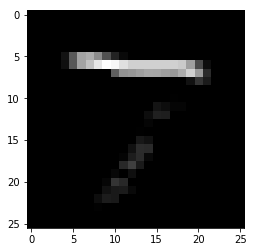

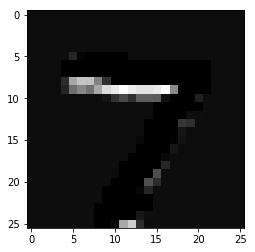

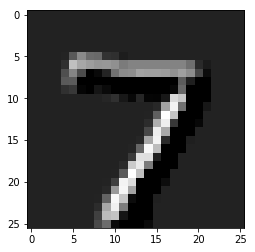

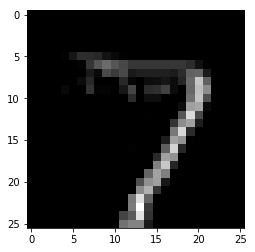

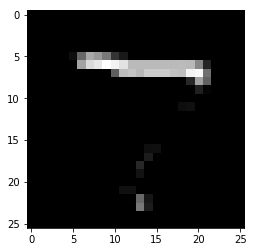

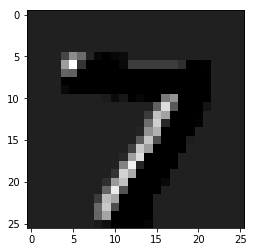

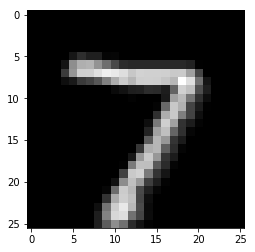

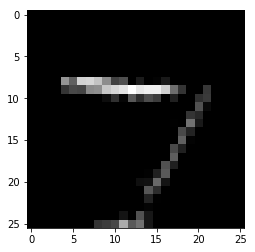

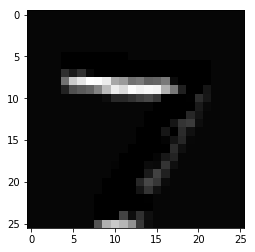

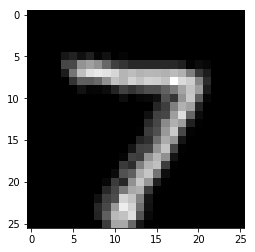

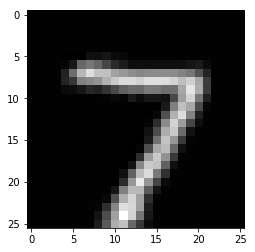

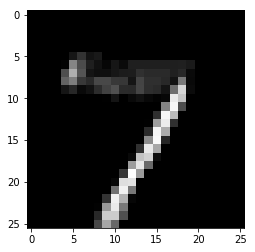

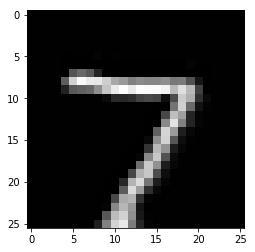

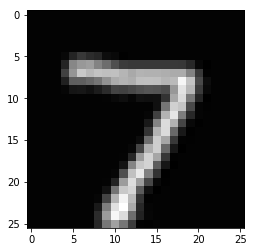

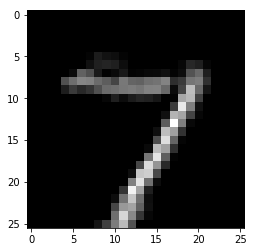

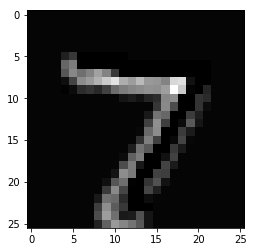

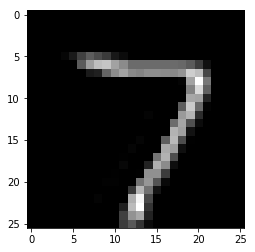

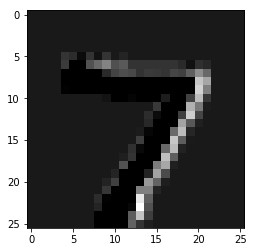

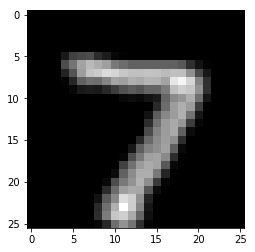

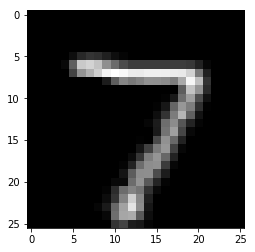

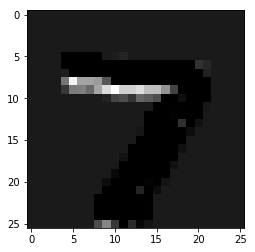

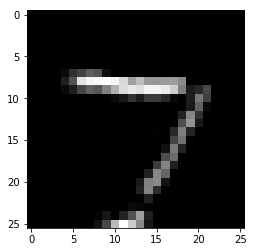

In [35]:
for i in range(32):
    plt.imshow(activations[0, ..., i])
    plt.show()

In [36]:
activations[0, 5:10, 5:10, 0]

array([[ 0.12313882,  0.07273569,  0.05022647,  0.        ,  0.        ],
       [ 0.1309115 ,  0.14641027,  0.18909475,  0.19199452,  0.16788514],
       [ 0.09613925,  0.1401405 ,  0.14798687,  0.1795305 ,  0.20586434],
       [ 0.04382331,  0.0247027 ,  0.02338777,  0.        ,  0.02700226],
       [ 0.02401066,  0.        ,  0.        ,  0.01109774,  0.00698234]], dtype=float32)

In [39]:
net_input_op = sess.graph.get_operation_by_name('conv2d_1/BiasAdd')
net_input_op.outputs[0]

<tf.Tensor 'conv2d_1/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>

In [40]:
net_inputs = sess.run(net_input_op.outputs[0], feed_dict={network_input: test_data[0:1]})
net_inputs.shape

(1, 26, 26, 32)

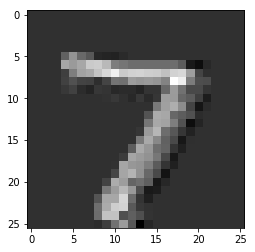

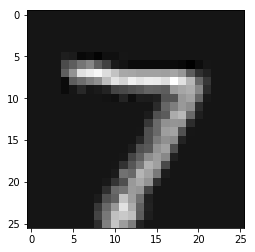

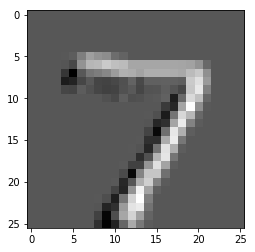

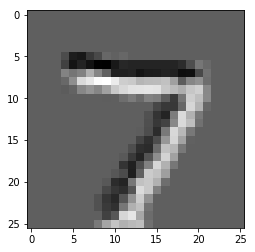

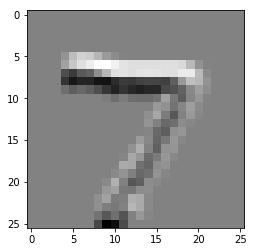

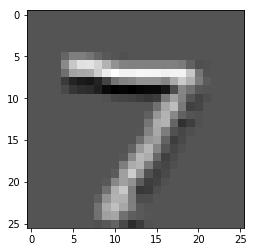

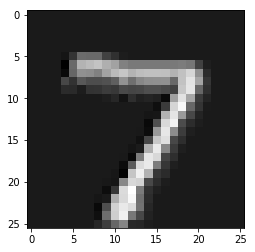

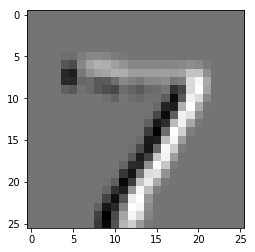

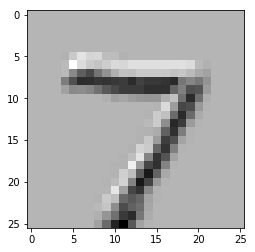

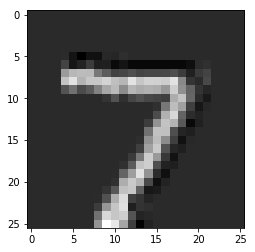

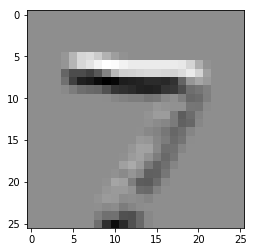

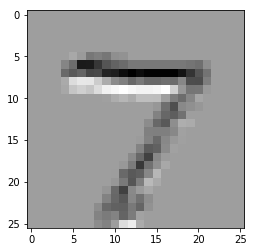

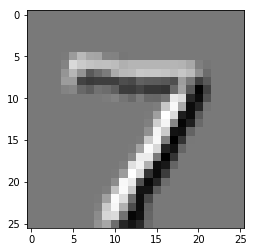

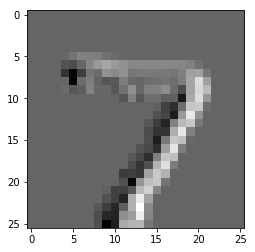

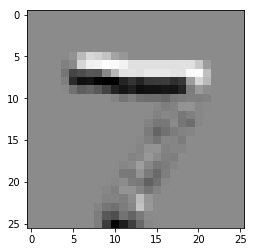

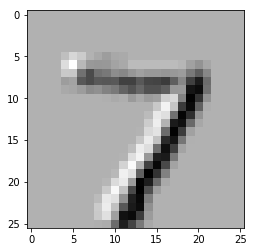

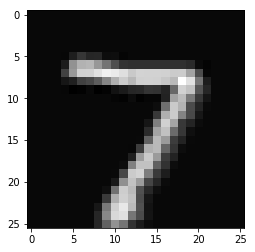

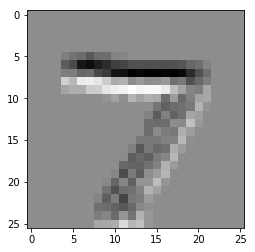

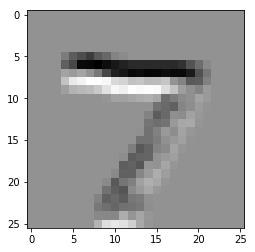

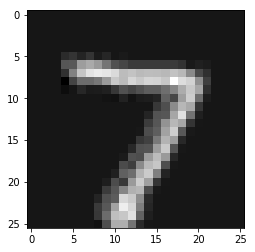

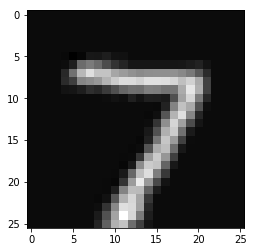

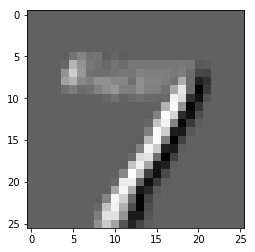

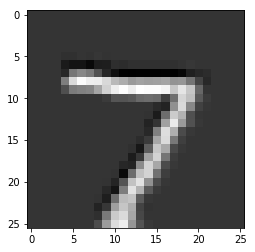

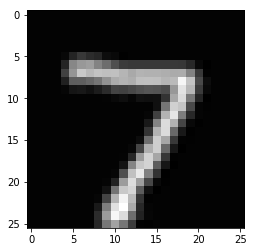

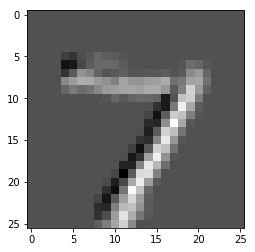

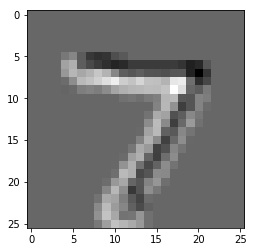

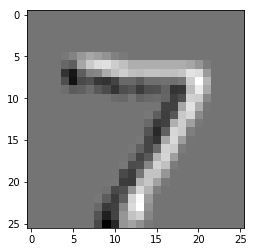

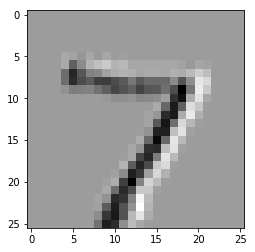

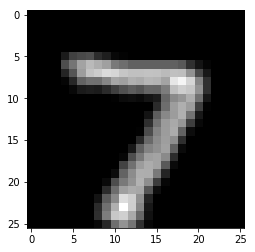

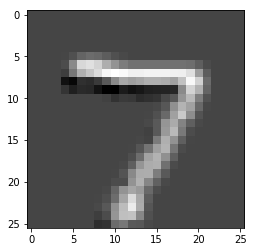

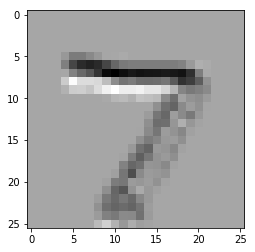

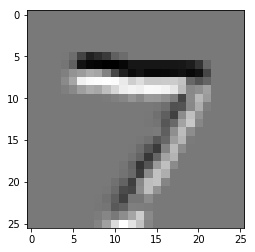

In [41]:
for i in range(32):
    plt.imshow(net_inputs[0, ..., i])
    plt.show()

In [42]:
net_inputs[0, 5:10, 5:10, 0]

array([[ 0.12313882,  0.07273569,  0.05022647, -0.00863712, -0.01102792],
       [ 0.1309115 ,  0.14641027,  0.18909475,  0.19199452,  0.16788514],
       [ 0.09613925,  0.1401405 ,  0.14798687,  0.1795305 ,  0.20586434],
       [ 0.04382331,  0.0247027 ,  0.02338777, -0.00067293,  0.02700226],
       [ 0.02401066, -0.00127091, -0.01244084,  0.01109774,  0.00698234]], dtype=float32)

### Getting input and output shape
For each tensor the shape can be retrieved as a `TensorShape` object or as a list.

In [64]:
conv_op.inputs[0].shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [65]:
conv_op.inputs[0].shape.as_list()

[None, 28, 28, 1]

### Getting layer properties
Internally TensorFlow represents graph as protobufs that only define nodes with their inputs. This definition can either be retrieved as globally `graph.graph_def` as as `op.node_def` for every single operation.

In [50]:
sess.graph_def

node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 28
        }
        dim {
          size: 28
        }
        dim {
          size: 1
        }
      }
    }
  }
}
node {
  name: "Placeholder_1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 10
        }
      }
    }
  }
}
node {
  name: "training/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_BOOL
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_BOOL
        tensor_shape {
        }
        bool_val: false
      }
    }
  }
}
node {
  name: "training"
  op: "PlaceholderWithDefault"
  input: "training/input"
  attr {
  

In [51]:
activation_op.node_def

name: "conv2d_1/Relu"
op: "Relu"
input: "conv2d_1/BiasAdd"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}

#### Kernel size
Kernel size is not defined in the protobuf, but has to be read from the weight tensor shape.

In [53]:
read_op = sess.graph.get_operation_by_name('conv2d_2/kernel/read')
read_op.outputs[0].shape.as_list()[:2]

[3, 3]

#### Padding

In [55]:
conv_op.node_def

name: "conv2d_1/convolution"
op: "Conv2D"
input: "Placeholder"
input: "conv2d_1/kernel/read"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "data_format"
  value {
    s: "NHWC"
  }
}
attr {
  key: "padding"
  value {
    s: "VALID"
  }
}
attr {
  key: "strides"
  value {
    list {
      i: 1
      i: 1
      i: 1
      i: 1
    }
  }
}
attr {
  key: "use_cudnn_on_gpu"
  value {
    b: true
  }
}

In [56]:
# The padding value has to be decoded from bytes into a string.
conv_op.node_def.attr['padding'].s.decode('utf8')

'VALID'

#### Strides

In [57]:
strides = conv_op.node_def.attr['strides']
strides.list.i[1], strides.list.i[2]

(1, 1)

#### Pool size
Pool size is defined as `ksize` in the maxpool definition.

In [58]:
max_pool_op = sess.graph.get_operation_by_name('max_pooling2d_1/MaxPool')
max_pool_op.node_def

name: "max_pooling2d_1/MaxPool"
op: "MaxPool"
input: "conv2d_1/Relu"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "data_format"
  value {
    s: "NHWC"
  }
}
attr {
  key: "ksize"
  value {
    list {
      i: 1
      i: 2
      i: 2
      i: 1
    }
  }
}
attr {
  key: "padding"
  value {
    s: "VALID"
  }
}
attr {
  key: "strides"
  value {
    list {
      i: 1
      i: 2
      i: 2
      i: 1
    }
  }
}

In [63]:
kernel = max_pool_op.node_def.attr['ksize']
kernel.list.i[1], kernel.list.i[2]

(2, 2)